We will be training Resnet to classify images in this file.

In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

device=torch.device('mps') # This refers to using mps gpus on a mac. If NVidia gpus available, can set to cuda


The architecture of Resnet is the following:
Input: batches of images of shape [batch_size, 3, 224, 224] (3 channels for RBG, square 224x224 pixel images).
Images are normalized according to a standard normalization transforms used for images.
The Neural Network layers are the following:
<ol>
  <li>Convolution layer [batch_size,3,224x224]->[batch_size,3,56,56]: 7x7 Conv2d with 2 stride, batch normalization, ReLU, and 3x3 max pooling with 2 stride.</li>
  <li>Residual Blocks: this version of Resnet Uses Basic Blocks.There are 4 Basic Blocks put in series. The basic block consists of Conv2D, Batch Normalization, ReLU, Conv2d, Batch Normalization, adding the (potentially downsampled)  identity) input back into the output (so called skip layer), and ReLU. Each block reduces the dimension of the output. </li>
  <li>Lastly, there is an average pool, a flattening, and a fully connected layer to the output classes.</li>
</ol>
 Succinctly,

| Layer     | Output Size | Details                                 |
|-----------|-------------|-----------------------------------------|
| Conv1     | 112x112      | 7x7 conv, stride=2, maxpool             |
| Layer 1   | 56x56        | 2 BasicBlocks, 64 filters               |
| Layer 2   | 28x28        | 2 BasicBlocks, 128 filters, stride=2     |
| Layer 3   | 14x14        | 2 BasicBlocks, 256 filters, stride=2     |
| Layer 4   | 7x7          | 2 BasicBlocks, 512 filters, stride=2     |
| Avg Pool  | 1x1          | Adaptive pooling                        |
| FC Layer  | 1x1          | Fully connected to output               |


In [3]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


model = resnet18(num_classes=10)  # For 10 classes
print(model)

# Test with random input
x = torch.randn(1, 3, 224, 224)
output = model(x)
print(output.shape)
print(output)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

As for the data
1) ImageNet was used.
2) Due to an issue with image net downloading (a very large file), I was unable to extract all of it
3) It turned into 4171 classes each containing at least 450 images.
4) The data was split into 70% train, 15 % validation, and 15% test. Due to my own failing to properly set up the training algorithm, the validation data was unused, but should have been used in the testing of various hyperparameters.


In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

# Define the data path
data_path = "/Users/ryanaschoff/Documents/ImageNet"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to tensors
    transforms.Normalize(           # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the entire dataset
full_dataset = ImageFolder(root=data_path, transform=transform)

# Define dataset sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # Remaining for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check dataset sizes
print(f"Total images: {dataset_size}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

# Example: Get a batch from the training loader
images, labels = next(iter(train_loader))
print(f"Batch size: {images.shape}, Labels: {labels}")


Total images: 4221501
Training images: 2955050
Validation images: 633225
Test images: 633226
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([ 933, 1385, 3341,  550,  561,  685,  251, 1604, 4148, 2663, 2511, 1904,
        3663, 1603, 2538, 2432, 1262, 3528, 4078, 1222,  871, 2754,  596, 3725,
        3918,  363,  466, 1852,   84, 2553, 1629, 3496])


We train for 10 epochs over all the images minimizing Cross Entropy using Adam. At this phase, it would be advisable to save after the end of each epoch. Moreover, it would have been advisable to use the validation data to determine if the model was overfitting. 

In [12]:


# Get the number of classes from the dataset
num_classes = len(full_dataset.classes)
model = resnet18(num_classes=num_classes).to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Training complete.")

/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1/10], Loss: 5.4748


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2/10], Loss: 3.6459


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3/10], Loss: 3.1452


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4/10], Loss: 2.8668


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5/10], Loss: 2.6719


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6/10], Loss: 2.5152


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7/10], Loss: 2.3821


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8/10], Loss: 2.2615


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9/10], Loss: 2.1502


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [10/10], Loss: 2.0457
Training complete.


Here we save the completed model. Cross Entropy has gone down for every epoch!

In [13]:
# Define the path to save the model weights
save_path = "/Users/ryanaschoff/Deep_Learning/resnet18_weights.pth"

# Save the model weights
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to /Users/ryanaschoff/Documents/resnet18_weights.pth


Test to see whether our trained model had worked. The code here is undesirable because I use the train loader instead of the test loader which would be more representative of whether we had actually fit well.

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ryanaschoff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


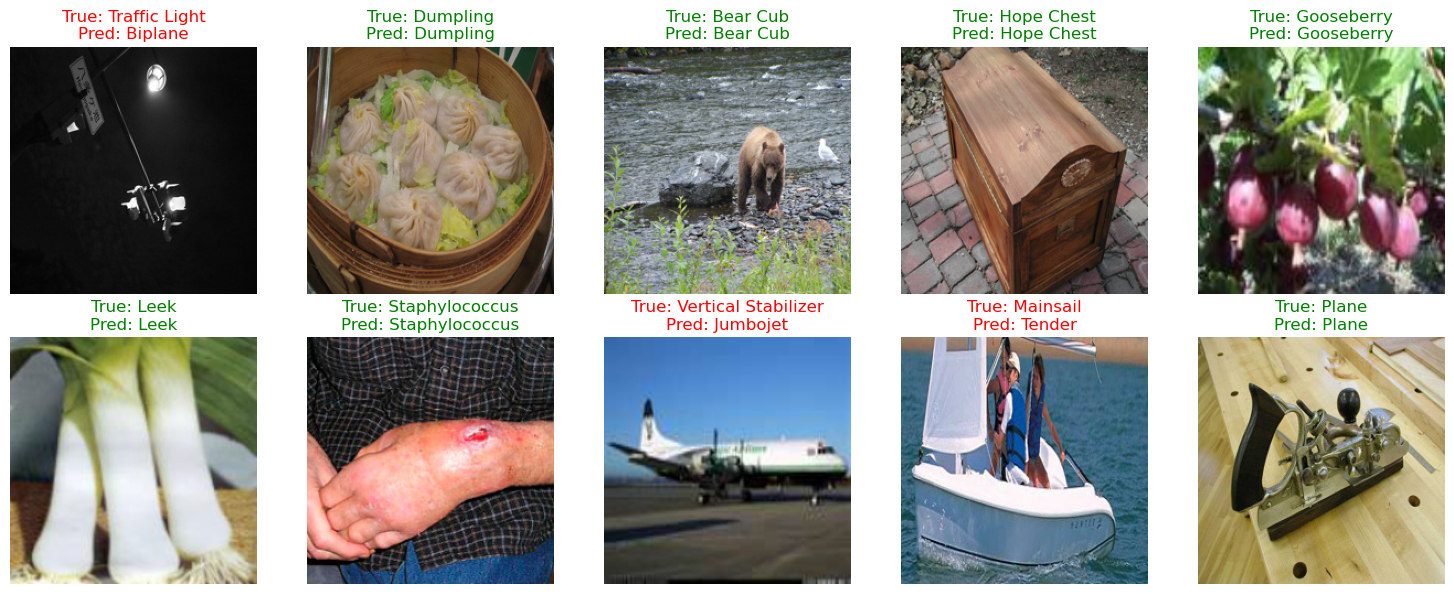

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torchvision import transforms
import nltk
from nltk.corpus import wordnet as wn

# Ensure NLTK resources are downloaded
nltk.download('wordnet')

# Load class names from the dataset
imagenet_classes = full_dataset.classes

# Function to convert ImageNet class names to human-readable names using nltk
def get_human_readable_label(imagenet_label):
    try:
        synset = wn.synset_from_pos_and_offset('n', int(imagenet_label[1:]))  # Extract synset
        return synset.lemmas()[0].name().replace('_', ' ').title()
    except Exception as e:
        return imagenet_label  # Return original label if conversion fails

# Convert all class labels to human-readable form
human_readable_labels = {idx: get_human_readable_label(label) for idx, label in enumerate(imagenet_classes)}

# Get a batch of images and labels from the train loader
images, labels = next(iter(train_loader))

# Move images to device
images = images.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move images and predictions back to CPU for visualization
images = images.cpu()
predicted = predicted.cpu()

# Function to denormalize the image for visualization
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.permute(1, 2, 0).numpy() * std + mean  # Denormalize
    image = np.clip(image, 0, 1)  # Clip to valid range
    return image

# Select first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img = denormalize(images[i])  # Convert tensor to image
    true_label = human_readable_labels[labels[i].item()]  # Get human-readable label
    pred_label = human_readable_labels[predicted[i].item()]  # Get human-readable predicted label

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", 
                      color=("green" if true_label == pred_label else "red"))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Without thinking, I try training once more to see if the cross entropy could decrease by any more. The issue with this again is that the validation data would be a better test to see if the decrease in cross entropy is actually meaningful to predicting unseen data.

In [17]:
# Training loop
num_epochs = 10  # Number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1/10], Loss: 1.9485


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2/10], Loss: 1.8575


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3/10], Loss: 1.7698


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4/10], Loss: 1.6880


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5/10], Loss: 1.6123


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6/10], Loss: 1.5408


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7/10], Loss: 1.4736


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8/10], Loss: 1.4117


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9/10], Loss: 1.3525


/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [10/10], Loss: 1.2981


In [18]:
# Define the path to save the model weights
save_path = "/Users/ryanaschoff/Documents/resnet18_weights_train_2.pth"

# Save the model weights
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to /Users/ryanaschoff/Documents/resnet18_weights_train_2.pth


Now we revisualize the output. At least on the training data, the outputs looks a bit better!

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ryanaschoff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


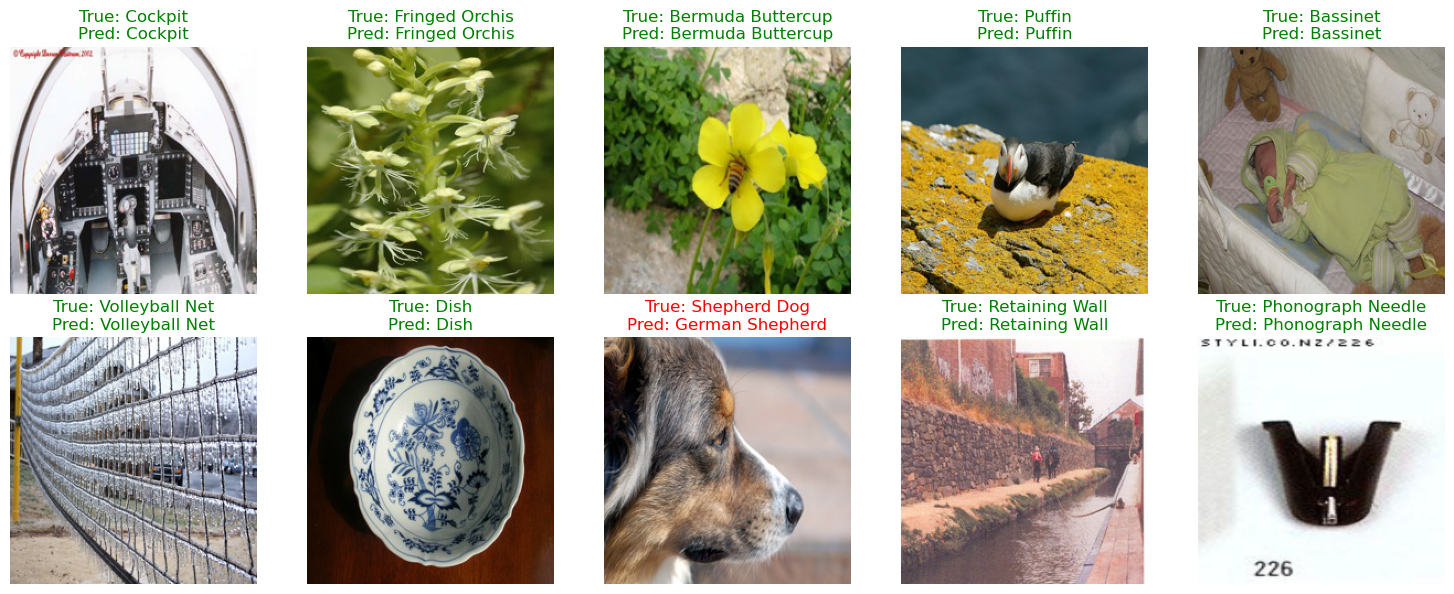

In [19]:

# Convert all class labels to human-readable form
human_readable_labels = {idx: get_human_readable_label(label) for idx, label in enumerate(imagenet_classes)}

# Get a batch of images and labels from the train loader
images, labels = next(iter(train_loader))

# Move images to device
images = images.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move images and predictions back to CPU for visualization
images = images.cpu()
predicted = predicted.cpu()

# Function to denormalize the image for visualization
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.permute(1, 2, 0).numpy() * std + mean  # Denormalize
    image = np.clip(image, 0, 1)  # Clip to valid range
    return image

# Select first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img = denormalize(images[i])  # Convert tensor to image
    true_label = human_readable_labels[labels[i].item()]  # Get human-readable label
    pred_label = human_readable_labels[predicted[i].item()]  # Get human-readable predicted label

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", 
                      color=("green" if true_label == pred_label else "red"))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Now we evaluate the output of the model using top 1 and top 5 accuracy.

In [23]:

# Function to calculate top-1 and top-5 accuracy
def evaluate_models(test_loader, device):
    for weights in ["/Users/ryanaschoff/Documents/resnet18_weights.pth","/Users/ryanaschoff/Documents/resnet18_weights_train_2.pth"]:
        
        model = resnet18(num_classes=num_classes).to(device)

        # Load the saved weights
        model.load_state_dict(torch.load(weights))
        print("Model weights loaded successfully.")

        model.eval()  # Set the model to evaluation mode
        top1_correct = 0
        top5_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate Top-1 accuracy (highest confidence)
                _, top1_pred = torch.max(outputs, 1)
                top1_correct += (top1_pred == labels).sum().item()

                # Calculate Top-5 accuracy
                _, top5_pred = torch.topk(outputs, 5, dim=1)  # Get top 5 predictions
                top5_correct += torch.sum(top5_pred.eq(labels.view(-1, 1)).sum(dim=1)).item()

                total += labels.size(0)

        top1_accuracy = 100 * top1_correct / total
        top5_accuracy = 100 * top5_correct / total

        print(f"Top-1 Accuracy with weights {weights}: {top1_accuracy:.2f}%")
        print(f"Top-5 Accuracy with weights {weights}: {top5_accuracy:.2f}%")

    return top1_accuracy, top5_accuracy

# Evaluate the model
top1_acc, top5_acc = evaluate_models(test_loader, device)

Model weights loaded successfully.


/var/folders/9j/9wkdxd0j7txf_562x77vfjdw0000gn/T/ipykernel_2212/3565492574.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights))


Top-1 Accuracy with weights /Users/ryanaschoff/Documents/resnet18_weights.pth: 37.33%
Top-5 Accuracy with weights /Users/ryanaschoff/Documents/resnet18_weights.pth: 63.60%
Model weights loaded successfully.
Top-1 Accuracy with weights /Users/ryanaschoff/Documents/resnet18_weights_train_2.pth: 33.62%
Top-5 Accuracy with weights /Users/ryanaschoff/Documents/resnet18_weights_train_2.pth: 59.66%


In [26]:
# Define the output file path
output_file_path = "/Users/ryanaschoff/Deep_Learning/resnet_classes.txt"

# Save the classes to a text file while preserving order
with open(output_file_path, "w") as f:
    for class_name in full_dataset.classes:
        f.write(f"{class_name}\n")

print(f"ResNet classes have been saved to {output_file_path}")

ResNet classes have been saved to /Users/ryanaschoff/Deep_Learning/resnet_classes.txt


Now we save the file of classes for later use in the next file.

Overall, very easy to set up. The model seems to work well! Now I will use this same model to to classify multiple objectings in the data annotation file. 